In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Readme.txt
/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Readme.docx
/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Readme.txt
/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Data Distribution.png
/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Readme.docx
/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/Nepal/Biratnagar/Biratnagar_AQI_All_info.csv
/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/Nepal/Biratnagar/d_Unhealthy/BRI_Un_2023-02-02- 12.00-11.jpg
/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/

In [64]:
import sys

from typing import Dict, Optional, Tuple
from pathlib import Path

import math

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend #Keras version 2.1.6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, LeakyReLU, Input, Conv2D, MaxPooling2D 

from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
#from PIL import Image

from sklearn.metrics import r2_score
from sklearn.utils import shuffle

%matplotlib inline

In [65]:
df = pd.read_csv('/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv')
df.head()

Location                        Filename  Year  Month  Day   Hour  \
0  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-9.jpg  2023      2    2  12:00   
1  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-8.jpg  2023      2    2  12:00   
2  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-7.jpg  2023      2    2  12:00   
3  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-6.jpg  2023      2    2  12:00   
4  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-5.jpg  2023      2    2  12:00   

   AQI  PM2.5    PM10     O3    CO  SO2   NO2    AQI_Class  
0  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  
1  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  
2  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  
3  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  
4  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy

In [66]:
df = shuffle(df)

df.sample(frac=1).reset_index(drop=True)

number_of_rows = 3000
sub_dfs = [df[i:i + number_of_rows] for i in range(0, df.shape[0], number_of_rows)]
for idx, sub_df in enumerate(sub_dfs):
    sub_df.to_csv(f'frag3000_{idx}.csv', index=False)

In [67]:
df = pd.read_csv('../working/frag3000_1.csv')
df.head(15)

Location                                 Filename  \
0                      ITO, Delhi        DEL_SEV_2023-02-20-14.00-3-51.jpg   
1                      ITO, Delhi       DEL_SEV_2023-02-20-14.00-1-196.jpg   
2                          Mumbai         MH_UH_2023-02-02- 09.30-1-40.jpg   
3                      ITO, Delhi       DEL_SEV_2023-02-07-14.00-1-127.jpg   
4                      ITO, Delhi       DEL_SEV_2023-02-20-14.00-3-316.jpg   
5                       Bengaluru     BENGR_Mod_2023-02-25-08.30-1-126.jpg   
6   Knowledge park, Greater Noida       UP_UHFSG_2023-02-08-08.30-1-74.jpg   
7                       Bengaluru     BENGR_Mod_2023-03-06-08.30-1-476.jpg   
8               Biratnagar, Nepal        BIR_MOD_2023-02-13-09.30-3-65.jpg   
9               Biratnagar, Nepal    BIR_UNH_VF_2023-02-02- 12.00-1-16.jpg   
10                     Tamil Nadu        TN_Good_2023-02-23-08.30-2-56.jpg   
11  Knowledge park, Greater Noida      UP_UHFSG_2023-02-08-08.30-1-115.jpg   
12  Knowledge park, Greater Noida       UP_UHFSG_2023-02-08-08.30-1-71.jpg   
13              Dimapur, Nagaland  Dimapur_UHFSG_2023-02-02- 09.00-3-6.jpg   
14                         Mumbai        MH_UnFSG_2023-02-15-10.30-1-9.jpg   

    Year  Month  Day   Hour  AQI   PM2.5    PM10     O3      CO   SO2     NO2  \
0   2023      2   20  14:00  363  257.00  139.00  41.00   65.00  35.0   83.00   
1   2023      2   20  14:00  363  257.00  139.00  41.00   65.00  35.0   83.00   
2   2023      2    2   9:30  182  115.80  188.50  25.30     NaN   NaN    9.50   
3   2023      2    7  14:00  449  337.00  198.00  23.00   24.00  13.0   57.00   
4   2023      2   20  14:00  363  257.00  139.00  41.00   65.00  35.0   83.00   
5   2023      2   25   8:30   73   29.00   64.00  23.00  189.00   7.0   16.00   
6   2023      2    8   8:30  133   34.00  199.00   2.00   28.00  16.0   47.00   
7   2023      3    6   8:30   68   36.00   59.00  22.00  171.00   5.0   14.00   
8   2023      2   13   9:30   91   30.27   44.12  42.15    0.30   4.1    2.57   
9   2023      2    2  12:00  158   70.08  100.82  58.89    0.49   4.4    1.04   
10  2023      2   23   8:30   43   21.00   36.00  10.00  410.00  15.0   13.00   
11  2023      2    8   8:30  133   34.00  199.00   2.00   28.00  16.0   47.00   
12  2023      2    8   8:30  133   34.00  199.00   2.00   28.00  16.0   47.00   
13  2023      2    2   9:00  103   53.00   84.00  13.00    2.00   3.0    5.00   
14  2023      2   15  10:00  143  334.00  276.00  14.00   77.00   NaN  160.00   

                           AQI_Class  
0                           f_Severe  
1                           f_Severe  
2                        d_Unhealthy  
3                           f_Severe  
4                           f_Severe  
5                         b_Moderate  
6   c_Unhealthy_for_Sensitive_Groups  
7                         b_Moderate  
8                         b_Moderate  
9                        d_Unhealthy  
10                            a_Good  
11  c_Unhealthy_for_Sensitive_Groups  
12  c_Unhealthy_for_Sensitive_Groups  
13  c_Unhealthy_for_Sensitive_Groups  
14  c_Unhealthy_for_Sensitive_Groups

In [68]:
def build_x(path):
    train_img = []
    for i in range(df.shape[0]):
        img = image.load_img(path + df['Filename'][i])
        img = image.img_to_array(img)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        #img = img / 255        # with respect to imagenet, no scaling be used
        train_img.append(img)

    x = np.array(train_img)
    return x

In [70]:
x_origin = build_x('/kaggle/input/air-pollution-image-dataset-from-india-and-nepal/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/')

In [71]:
x_origin.shape

(3000, 224, 224, 3)

In [72]:
pm10 =pd.DataFrame(df['PM10'])
pm10

PM10
0     139.0
1     139.0
2     188.5
3     198.0
4     139.0
...     ...
2995  113.0
2996   90.8
2997  276.0
2998   52.0
2999  169.0

[3000 rows x 1 columns]

In [73]:
x_origin_train, x_origin_temp, y_train, y_temp = train_test_split(x_origin, pm10, train_size=0.8, shuffle=True)

In [75]:
x_origin_valid, x_origin_test, y_valid, y_test = train_test_split(x_origin_temp, y_temp, test_size=0.5, shuffle=True)

In [76]:
x_origin_train.shape

(2400, 224, 224, 3)

In [77]:
y_train.shape

(2400, 1)

In [78]:
x_origin = []
x_origin_temp = []
y_temp = []
y = []

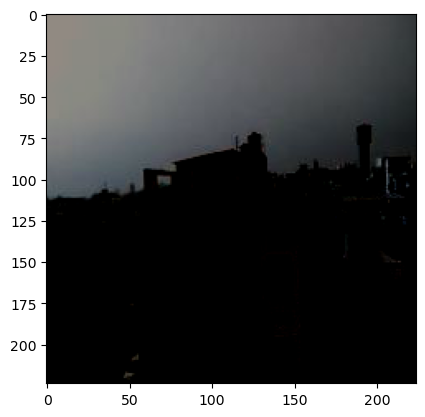

In [79]:
plt.imshow(x_origin_test[10]/255)

In [80]:
y_test = y_test.reset_index(drop=True)
y_test

PM10
0     63.00
1    480.00
2    180.00
3     48.66
4     44.12
..      ...
295  199.00
296  111.00
297  106.00
298  185.00
299  100.82

[300 rows x 1 columns]

In [81]:
y_test.head(15)

PM10
0    63.00
1   480.00
2   180.00
3    48.66
4    44.12
5    49.00
6    53.00
7   198.00
8   357.00
9    47.00
10  199.00
11  122.00
12   61.00
13  100.82
14  276.00

In [82]:
pre_trained_model  = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [83]:
x1 = Flatten()(pre_trained_model.output)
fc1 = Dense(512, activation = 'relu')(x1)
fc2 = Dense(512, activation = 'relu')(fc1)
x = Dense(1, activation='linear')(fc2)
model = Model(pre_trained_model.input, x)
    
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=opt)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [84]:
weight_path="{}_aqi.best.hdf5".format('vgg16')

In [85]:
callback = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto'),
    ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                    save_best_only=True, mode='min', save_weights_only = True)]
history = model.fit(x=x_origin_train, y=y_train, validation_data=(x_origin_valid, y_valid), batch_size=16, epochs=150, callbacks=callback)

Epoch 1/150
150/150 [==============================] - ETA: 0s - loss: 4803.8594
Epoch 1: val_loss improved from inf to 1725.93713, saving model to vgg16_aqi.best.hdf5
150/150 [==============================] - 13s 80ms/step - loss: 4803.8594 - val_loss: 1725.9371
Epoch 2/150
150/150 [==============================] - ETA: 0s - loss: 1539.2842
Epoch 2: val_loss did not improve from 1725.93713
150/150 [==============================] - 11s 75ms/step - loss: 1539.2842 - val_loss: 1853.9479
Epoch 3/150
150/150 [==============================] - ETA: 0s - loss: 920.9786
Epoch 3: val_loss improved from 1725.93713 to 1381.70935, saving model to vgg16_aqi.best.hdf5
150/150 [==============================] - 12s 78ms/step - loss: 920.9786 - val_loss: 1381.7094
Epoch 4/150
150/150 [==============================] - ETA: 0s - loss: 678.4355
Epoch 4: val_loss did not improve from 1381.70935
150/150 [==============================] - 12s 77ms/step - loss: 678.4355 - val_loss: 1530.2950
Epoch 5/150

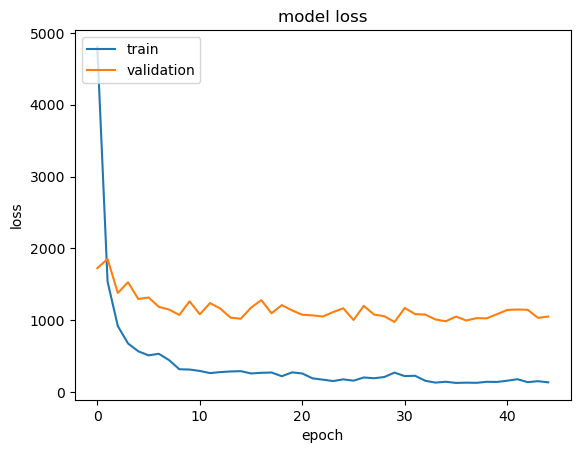

In [87]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [88]:
model.load_weights(weight_path)

In [89]:
loss = model.evaluate(x=x_origin_test, y=y_test, batch_size=16)
print('RMSE is :', loss ** 0.5)

19/19 [==============================] - 1s 66ms/step - loss: 1219.9894
RMSE is : 34.92834636627982


In [90]:
y_predict = model.predict(x_origin_test)

10/10 [==============================] - 1s 123ms/step


In [91]:
from sklearn.metrics import r2_score

r2_score(y_test, y_predict)

0.8866157110738022

In [92]:
y_predict_pm10 = np.zeros(len(y_predict))

for i in range(len(y_predict)):
    if y_predict[i] <= 54:
        y_predict_pm10[i] = 0
    elif y_predict[i] >= 55 and y_predict[i] <= 154:
        y_predict_pm10[i] = 1
    elif y_predict[i] >= 155 and y_predict[i] <= 254:
        y_predict_pm10[i] = 2
    elif y_predict[i] >= 255 and y_predict[i] <= 354:
        y_predict_pm10[i] = 3
    elif y_predict[i] >= 355 and y_predict[i] <= 424:
        y_predict_pm10[i] = 4
    elif y_predict[i] > 424:
        y_predict_pm10[i] = 5
    else:
        print('Exception Occured!')
    
y_predict_pm10 = y_predict_pm10.astype(int)
    
    
y_predict_pm10

Exception Occured!
Exception Occured!
Exception Occured!
Exception Occured!
Exception Occured!


array([1, 4, 2, 1, 0, 1, 1, 1, 3, 0, 2, 1, 1, 1, 2, 1, 1, 0, 5, 2, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 3, 2, 2, 1, 1, 1,
       2, 1, 1, 0, 3, 1, 1, 2, 0, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 2,
       0, 1, 1, 0, 5, 1, 0, 2, 2, 0, 3, 2, 0, 2, 1, 2, 3, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 2, 1, 3, 0, 2, 0, 5, 1, 1, 0, 2, 1, 2, 1, 1, 1, 0,
       2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1,
       4, 3, 1, 2, 5, 1, 1, 1, 2, 4, 1, 2, 2, 1, 2, 2, 1, 3, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 4, 1, 1, 1, 0, 1,
       1, 2, 1, 2, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 2,
       1, 1, 1, 1, 1, 3, 2, 2, 2, 3, 1, 1, 0, 4, 5, 1, 2, 1, 0, 1, 2, 3,
       3, 1, 0, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 3, 1, 1, 0, 1, 1, 2, 1,
       1, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 0, 1, 2, 5, 2, 2, 1, 1,
       1, 0, 0, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 5, 1, 0, 1, 1, 1, 2,
       4, 5, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1])

In [93]:
y_test = y_test.to_numpy().tolist()
y_test

[[63.0],
 [480.0],
 [180.0],
 [48.66],
 [44.12],
 [49.0],
 [53.0],
 [198.0],
 [357.0],
 [47.0],
 [199.0],
 [122.0],
 [61.0],
 [100.82],
 [276.0],
 [63.0],
 [122.0],
 [48.66],
 [480.0],
 [180.0],
 [108.0],
 [95.23],
 [132.0],
 [106.0],
 [48.66],
 [48.66],
 [166.0],
 [169.0],
 [36.0],
 [199.0],
 [345.0],
 [90.8],
 [84.0],
 [198.0],
 [199.0],
 [113.0],
 [232.0],
 [48.66],
 [199.0],
 [198.0],
 [169.0],
 [95.23],
 [106.0],
 [113.0],
 [248.0],
 [99.0],
 [113.0],
 [32.0],
 [272.0],
 [95.23],
 [68.92],
 [188.5],
 [36.0],
 [93.75],
 [36.0],
 [113.0],
 [181.0],
 [139.0],
 [86.0],
 [272.0],
 [47.0],
 [132.0],
 [27.0],
 [84.0],
 [48.66],
 [120.0],
 [46.0],
 [48.66],
 [48.66],
 [28.0],
 [480.0],
 [98.72],
 [44.12],
 [168.0],
 [188.0],
 [53.0],
 [345.0],
 [199.0],
 [43.0],
 [199.0],
 [61.0],
 [199.0],
 [325.0],
 [106.0],
 [44.12],
 [113.0],
 [32.0],
 [194.0],
 [78.0],
 [63.0],
 [69.0],
 [90.0],
 [59.0],
 [182.0],
 [106.0],
 [272.0],
 [48.66],
 [199.0],
 [27.0],
 [466.0],
 [100.82],
 [111.0],
 [47.0]

In [94]:
y_test[1][0]

480.0

In [95]:
#Classify the Ground Truth PM10 concentration to the air quality levels

y_test_pm10 = np.zeros(len(y_test))

for i in range(len(y_test)):
    if int(y_test[i][0])  <= 54:
        y_test_pm10[i] = 0
    elif int(y_test[i][0]) >= 55 and int(y_test[i][0]) <= 154:
        y_test_pm10[i] = 1
    elif int(y_test[i][0]) >= 155 and int(y_test[i][0]) <= 254:
        y_test_pm10[i] = 2
    elif int(y_test[i][0]) >= 255 and int(y_test[i][0]) <= 354:
        y_test_pm10[i] = 3
    elif int(y_test[i][0]) >= 355 and int(y_test[i][0]) <= 424:
        y_test_pm10[i] = 4
    elif int(y_test[i][0]) > 424:
        y_test_pm10[i] = 5
    else:
        print('Exception Occured!')

y_test_pm10 = y_test_pm10.astype(int)
        
        
y_test_pm10

array([1, 5, 2, 0, 0, 0, 0, 2, 4, 0, 2, 1, 1, 1, 3, 1, 1, 0, 5, 2, 1, 1,
       1, 1, 0, 0, 2, 2, 0, 2, 3, 1, 1, 2, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1,
       2, 1, 1, 0, 3, 1, 1, 2, 0, 1, 0, 1, 2, 1, 1, 3, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 5, 1, 0, 2, 2, 0, 3, 2, 0, 2, 1, 2, 3, 1, 0, 1, 0, 2,
       1, 1, 1, 1, 1, 2, 1, 3, 0, 2, 0, 5, 1, 1, 0, 2, 1, 2, 1, 1, 1, 0,
       2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 2,
       4, 3, 0, 3, 5, 1, 1, 1, 2, 4, 1, 2, 2, 1, 2, 2, 2, 4, 0, 1, 1, 2,
       2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 5, 0, 1, 1, 0, 1,
       1, 2, 1, 2, 1, 1, 0, 0, 0, 3, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 1,
       1, 1, 1, 1, 1, 3, 2, 2, 2, 3, 0, 1, 0, 3, 5, 1, 2, 1, 0, 1, 2, 4,
       4, 1, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 3, 2, 5, 1, 1, 0, 1, 1, 2, 1,
       1, 3, 0, 0, 1, 0, 1, 2, 1, 0, 0, 2, 1, 3, 0, 1, 2, 4, 2, 1, 2, 1,
       0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 5, 1, 0, 2, 1, 1, 2,
       4, 5, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1])

In [96]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test_pm10, y_predict_pm10)

0.6651952615111748

In [97]:
#---Classification Accuracy for PM2.5---------

t = 0
n = 0

for i in range(len(y_predict_pm10)):
    if y_predict_pm10[i] == y_test_pm10[i]:
        t = t + 1
    else:
        n = n + 1
        
acc = t / len(y_predict_pm10)

print('Acc: ', acc, ' True: ', t, ' False: ', n)

Acc:  0.8166666666666667  True:  245  False:  55


In [98]:
from sklearn.metrics import f1_score

f1_score(y_test_pm10, y_predict_pm10, average='macro')

0.699023457985561

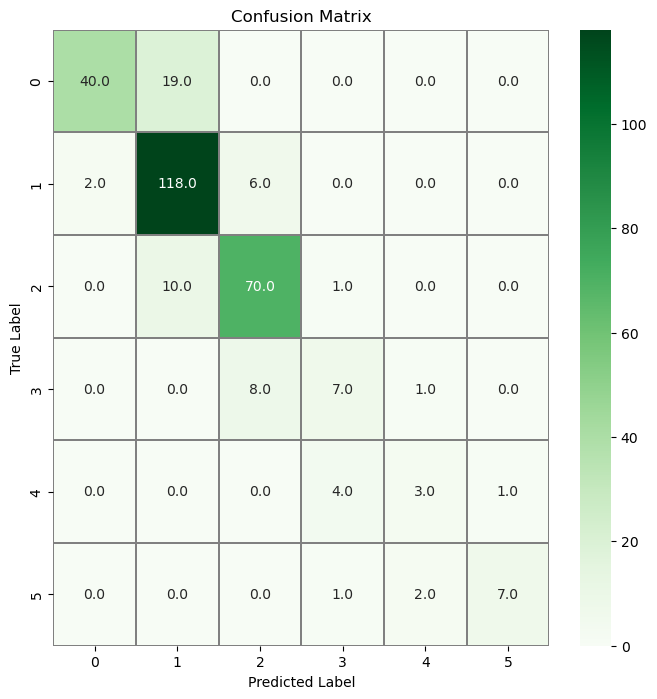

In [99]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
Y_pred_classes = y_predict_pm10
Y_true = y_test_pm10
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

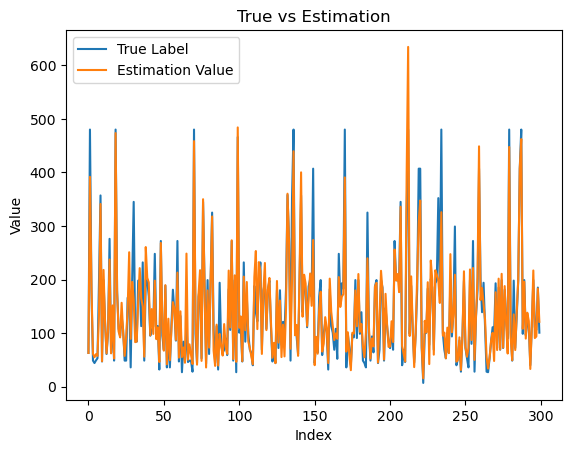

In [100]:
plt.plot(y_test, label='True Label')
plt.plot(y_predict, label='Estimation Value')

# set the x-axis label
plt.xlabel('Index')

# set the y-axis label
plt.ylabel('Value')

# set the plot title
plt.title('True vs Estimation')

# Adding a legend
plt.legend()

# display the plot
plt.show()